In [1]:
library(data.table)
library(ggplot2)

In [2]:
cell.types=c('B', 'cM', 'ncM', 'Th', 'Tc', 'cDC', 'MK', 'NK', 'PBMC')

genotype_pcs=read.table('/ye/yelabstore2/10x.lupus/eqtls/genotypes/demux.v2/v2.all.eigensoft.evec')
rownames(genotype_pcs)=gsub(':', '_', genotype_pcs$V1)
genotype_pcs=genotype_pcs[, -1]

In [3]:
getQTLData <- function(chr, pos, gene){
    snp=paste(chr, pos, sep=':')
    genos.sle=fread(paste('/ye/yelabstore3/10x.lupus/eqtls/sle.genotypes/chr', chr, '.genotypes.matrix.eqtl.txt', sep=''))
    genos.healthy=fread(paste('/ye/yelabstore3/10x.lupus/eqtls/healthy.genotypes/chr', chr, '.immvar.genotypes.matrix.eqtl.txt', sep=''))
    
    adj.expr=c()
    all.covs=NULL
    pvals=c()
    for(c in cell.types){
        print(c)
    #get het pval
        if(c != 'PBMC'){
            res=fread(paste('/ye/yelabstore3/10x.lupus/eqtls/sle.10pcs.subtracted/', c, '.', chr, '.matrix.eqtl.cis.txt', sep=''))
#            print(gene)
            res.use=res[which(res$SNP==paste(chr, pos, sep=':')), ]
            id=match(gene, res.use$gene)
            res.use=res.use[id, ]
            ct.effect=fread(paste('/ye/yelabstore3/10x.lupus/eqtls/v5/sle.10pcs/', c, '.', chr, '.matrix.eqtl.cis.txt', sep=''))
            ct.effect.use=ct.effect[which(ct.effect$SNP==paste(chr, pos, sep=':')), ]
            id=match(gene, ct.effect.use$gene)
            ct.effect.use=ct.effect.use[id, ]
            ct.effect.label=paste('beta:', round(ct.effect.use$beta, digits=3), '\np:', format.pval(ct.effect.use$"p-value"))
    }
            
    expr=fread(paste( '/ye/yelabstore3/10x.lupus/eqtls/v5.full.', c, '.blind.expr.txt', sep=''))
    sample_id=read.table(paste('/ye/yelabstore3/10x.lupus/eqtls/v5.full.', c, '.blind.covs.txt', sep=''), header=T)
    rm=intersect(grep('IGTB', sample_id$ind), grep('lupus', sample_id$batch))
    samples=sample_id[-rm, ]$ind
    gene_names=expr$V1
    expr=data.frame(expr[, -1, with=F])
    expr=expr[, -rm,]
#    print(dim(expr))
    colnames(expr)=samples
    
    m=match(gene, gene_names)
#    print(m)
    exp.gene=as.numeric(expr[m,])
    cov=t(read.table(paste('/ye/yelabstore3/10x.lupus/eqtls/v5.full.', c, '.covariates.txt', sep=''), check.names=F)[1:10,])
    cov=cov[-rm, ]
    rownames(cov)=samples

    genotype_pcs.use=genotype_pcs[match(samples, rownames(genotype_pcs)), ]
#    print(dim(genotype_pcs.use))
    cov=cbind(cov, genotype_pcs.use[, 1:7 ])

    if(c!='PBMC'){ 
        df=data.frame(expr=exp.gene, label=format.pval(res.use$"p-value"), ct_label=ct.effect.label, cov)
        } else{
        df=data.frame(expr=exp.gene, label=NA, ct_label=NA, cov)
        }
    all.covs=rbind(all.covs, df)
#    print(head(df))
    res=lm(data=df, expr~PC1+PC2+PC3+PC4+PC5)$residuals+mean(exp.gene)
    adj.expr=c(adj.expr,res)
    
    }
    ct=rep(cell.types, each=length(res))
    print('genotypes')
    genos.use=cbind(genos.sle[match(snp, genos.sle$V1), -1, with=F], genos.healthy[match(snp, genos.healthy$V1), -1, with=F])
    g=rep(as.numeric(genos.use)[match(colnames(expr), names(genos.use))], length(cell.types))

    #print(g)
    id=rep(colnames(expr), length(cell.types))

    df=data.frame(expr=adj.expr, genotype=g, cell=as.factor(ct), id=id, all.covs)
    df$disease='SLE'
    df$disease[grep('IGTB', df$id)]='Healthy'

#may as well put in the pops while we're adding information..

    clin=read.table('/ye/yelabstore2/10x.lupus/clinical.data/v2/v2.clinical.data.txt', sep='\t', header=T)
    df$racedesc=clin$racedesc[match(df$id, clin$genotypeid)]
    
    ifn=read.table('/ye/yelabstore3/10x.lupus/eqtls/v5.ifi6.sig.txt')
    df$ifn=ifn[match(df$id,rownames(ifn)),]
    
    return(df)    
}



 

In [14]:
# df=getQTLData(11, 118178007, 'CD3E')
# save(df, file='data/CD3E.rda')

# df=getQTLData(19, 10449358, 'ICAM3')
# save(df, file='data/ICAM3.rda')

# df=getQTLData(22, 39358037, 'APOBEC3B')
# save(df, file='data/APOBEC3B.rda')

df=getQTLData(1, 161478810, 'HSPA6')
save(df, file='data/HSPA6.rda')


#save(df, file=paste(df.out, '.rda',sep=''))
    

Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/sle.genotypes/chr", :
“Detected 119 column names but the data has 120 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/healthy.genotypes/chr", :
“Detected 46 column names but the data has 47 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "B"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "cM"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "ncM"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "Th"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "Tc"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "cDC"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "MK"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "NK"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "PBMC"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "genotypes"


In [8]:
# df=getQTLData(1, 161478810, 'HSPA6')

# pdf(paste('figures/HSPA6.pdf', sep=''), width=11, height=3,useDingbats=F)
# plt=ggplot(df[df$disease=='SLE', ], aes(x=as.factor(genotype), y=expr, fill=disease)) + geom_boxplot(position='dodge', outlier.colour = NA)+ scale_fill_brewer(palette="Set2") + facet_wrap( ~ cell+label+ct_label, scales="free", nrow=1 ) + theme_bw()  + theme(legend.position="none")
# print(plt)
# dev.off()
# #print(plt)


df.icam3=getQTLData(19, 10449358, 'ICAM3')

pdf(paste('figures/ICAM3.pdf', sep=''), width=11, height=3,useDingbats=F)
print(plt)
plt=ggplot(df.icam3[df.icam3$disease=='SLE', ], aes(x=as.factor(genotype), y=expr, fill=disease)) + geom_boxplot(position='dodge', outlier.colour = NA)+ scale_fill_brewer(palette="Set2") + facet_wrap( ~ cell+label+ct_label, scales="free", nrow=1 ) + theme_bw()  + theme(legend.position="none")
dev.off()


#IFN interaction
# plt=ggplot(df[df$disease=='SLE', ], aes(x=ifn, y=expr, color=as.factor(genotype)))+ geom_point() + facet_wrap( ~ cell , nrow=1, scales='free') + theme_bw() + scale_color_brewer(palette="Set2") + theme(legend.position="none") + geom_smooth(method='lm', se=FALSE)
# #plt=plt+xlab(paste(chr, pos))
# print(plt)

Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/sle.genotypes/chr", :
“Detected 119 column names but the data has 120 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/healthy.genotypes/chr", :
“Detected 46 column names but the data has 47 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "B"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "cM"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "ncM"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "Th"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "Tc"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "cDC"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "MK"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "NK"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "PBMC"


Warning message in fread(paste("/ye/yelabstore3/10x.lupus/eqtls/v5.full.", c, ".blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

[1] "genotypes"


png 
  2

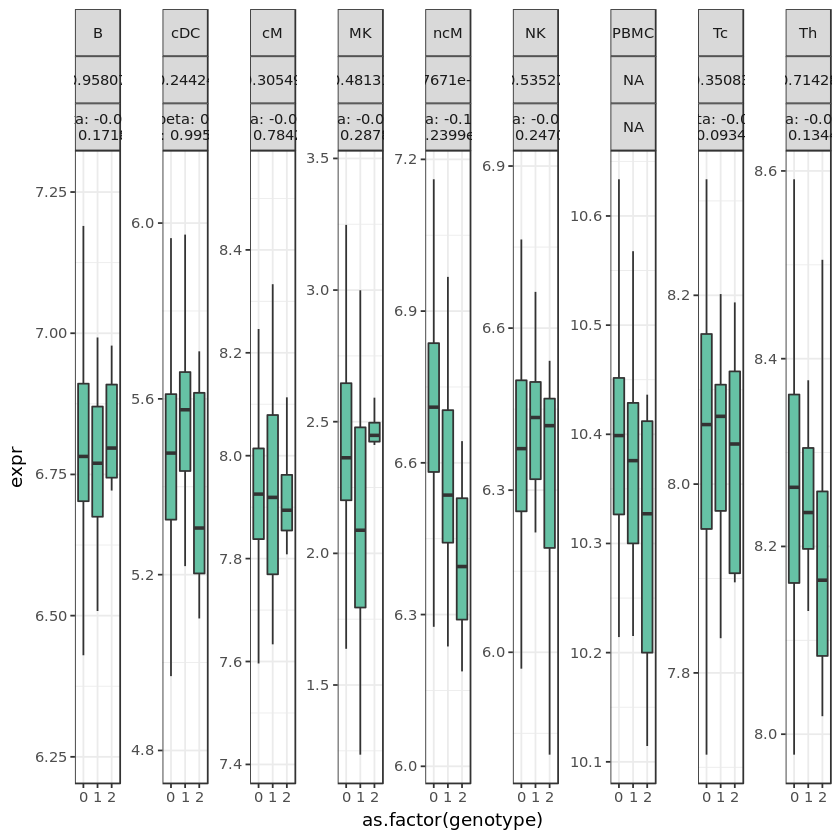

In [7]:
print(plt)